The objective of this notebook is to try learning a binary classifier from intervals of probabilities and not hard labels (example : $z_i = (x_i, y_i)$ with $y_i = 1$ is a classical case in learning problems, here we want to learn a classifier using $z_i = (x_i, y_i)$ with $y_i = [0.6, 0.76]$

# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

from scipy.special import rel_entr

# Load dataset

In [2]:
df = pd.read_csv("SynthPara_n1000_p2.csv")
df.head()

,X1,X2,z
0,3.119353,7.100552,B
1,-3.850261,-4.934919,A
2,-4.214494,-7.396423,A
3,3.197394,4.783222,B
4,-4.296943,-4.839382,A


In [3]:
df.shape

(1000, 3)

We have to predictors and one response variable with label A or B (i.e 0 or 1). First let's plot our data to see the decision boundary 

## plot data

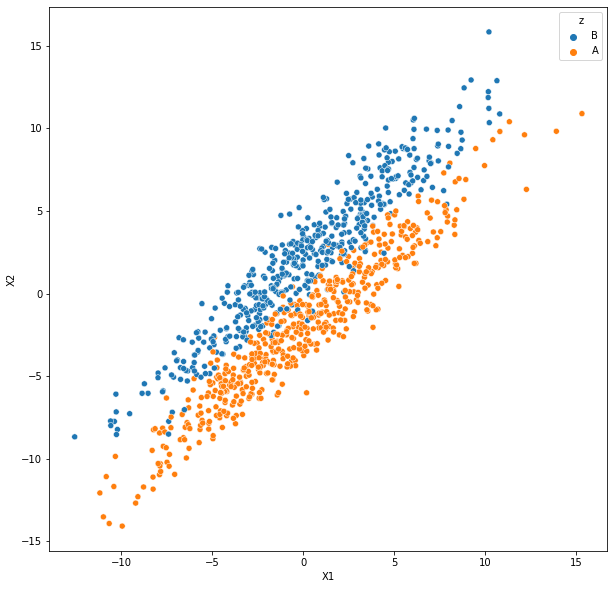

In [4]:
plt.figure(figsize=(10, 10))
sns.scatterplot(data=df, x="X1", y="X2", hue="z")
plt.show()

The decision boundary seems to be a linear function

## Add intervals

We first add random intervals of probabilities representing the following probability: $p(Y=A|X=x)$

In [5]:
def transform_to_interval(variable: str) -> np.ndarray:
    """
    Transform a hard label into an interval of probabilities.
    If the label is 0, the created interval will be in the range of
    [0, 0.49], else it will be in the range of [0.5, 1]
    
    Args:
        variable (int): variable to transform
    
    Returns:
        (np.ndarray): created interval 
    """
    if variable == "B":
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.0,
                    high=0.49,
                    size=(2,)
                ),
                decimals=2
            )
        )
    else:
        interval = np.sort(
            np.round(
                np.random.uniform(
                    low=0.5,
                    high=1.0,
                    size=(2,)
                ),
                decimals=2
            )
        )
    return interval

In [6]:
df["interval"] = df["z"].apply(transform_to_interval)
df.head()

,X1,X2,z,interval
0,3.119353,7.100552,B,"[0.03, 0.4]"
1,-3.850261,-4.934919,A,"[0.5, 0.72]"
2,-4.214494,-7.396423,A,"[0.68, 0.8]"
3,3.197394,4.783222,B,"[0.03, 0.46]"
4,-4.296943,-4.839382,A,"[0.69, 0.96]"


# Loss function

The objective now is trying to find a loss function applicable on intervals with the following properties: 

Let $\mathcal{L}$ being a loss function, $p_{inf}(Y|X=x)$ the lower bound of our intervals of probabilities, $p_{sup}(Y|X=x)$ the upper bound and $\hat{p}{Y|X=x)$ the predicted probability by a model of Y being A knowing X

We fix the loss function with the following:

- $\mathcal{L}(p_{inf}(Y|X=x), \hat{p}(Y|X=x))$ if $\hat{p}(Y|X=x) \notin [p_{inf}(Y|X=x), p_{sup}(Y|X=x)$ and $\hat{p}(Y|X=x) < p_{inf}(Y|X=x)$

- $0$ if $\hat{p}(Y|X=x) \in [p_{inf}(Y|X=x), p_{sup}(Y|X=x)]$ 

- $\mathcal{L}(p_{sup}(Y|X=x), \hat{p}(Y|X=x))$ if $\hat{p}(Y|X=x) \notin [p_{inf}(Y|X=x), p_{sup}(Y|X=x)$ and $\hat{p}(Y|X=x) > p_{sup}(Y|X=x)$

The Loss function we will use is the Kullback-Leibler divergence given by the formula:

Let $\mathcal{Y}$ being the label space, $p_y(Y=y|X=x)$ the probability that y is the label of X and $q_y(Y=y|X=x)$ the probability predicted by the model of y being the label of X
$$
D_{KL}(p||q) = \sum_{y \in \mathcal{Y}}p_y(Y=y|X=x)\ln(\frac{p_y(Y=y|X=x)}{q(Y=y|X=x)})
$$

In our binary case, $D_{KL}$ is given by this formula:

$$
D_{KL}(p(Y=1|X=x)||q(Y=1|X=x)) = p(Y=1|X=x)\ln(\frac{p(Y=1|X=x)}{q(Y=1|X=x)}) + (1-p(Y=1|X=x))\ln(\frac{1-p(Y=1|X=x)}{1-q(Y=1|X=x)})
$$

This loss function verify the 3 properties we mentionned above

Proof:

Consider a given $q(Y=1|X=x)$, we want to see if we can have $D_{KL}=0$ if $q(Y=1|X=x) \in [p_{inf}(Y=1|X=x), p_{sup}(Y=1|X=x)]$. We note $q(Y=1|X=x)=q$, $p_{inf}(Y=1|X=x) = p_i$, $p_{sup}(Y=1|X=x) = p_s$ and more generally $p(Y=1|X=x) = p$. Let differenciate $D_{KL}$ according to $p$ to see if can have a minimum, what is this minimum and what is the value of $D_{KL}$:

$$
\frac{\partial D_{KL}}{\partial p} = \ln(\frac{p}{q}) - \ln(\frac{1-p}{1-q}) \\
$$
So
$$
\begin{split}
\frac{\partial D_{KL}}{\partial p} = 0 \\
\Leftrightarrow \ln(\frac{p}{q}) = \ln(\frac{1-p}{1-q}) \\
\Leftrightarrow \frac{p}{q} = \frac{1-p}{1-q} \\
\Leftrightarrow p - pq = q - pq \\
\Leftrightarrow p = q \\
\end{split}
$$

We have a minimum for $p=q$, and $p=q \Rightarrow D_{KL} = p\ln(1) + (1-p)\ln(1) = 0$

So if $q \in [p_i, p_s]$ then $D_{KL} = 0$ 

And as $D_{KL}$ is convex, if $q < p_i$ then min $D_{KL} = D_{KL}(p_i || q)$ (same for max $D_{KL}$)

# Apply loss function 

In [7]:
df["label"] = df["z"].apply(lambda x: 1 if x=="A" else 0)
df.head()

,X1,X2,z,interval,label
0,3.119353,7.100552,B,"[0.03, 0.4]",0
1,-3.850261,-4.934919,A,"[0.5, 0.72]",1
2,-4.214494,-7.396423,A,"[0.68, 0.8]",1
3,3.197394,4.783222,B,"[0.03, 0.46]",0
4,-4.296943,-4.839382,A,"[0.69, 0.96]",1


## Get $\hat{p}(Y|X=x)$

To test the loss function, we need to compute $\hat{p}(Y=1|X=x)$. To do this, we train a logistic regression with just one iteration

In [8]:
lr = LogisticRegression(max_iter=1)
lr.fit(df[["X1", "X2"]], df["label"])
df["p_hat"] = lr.predict_proba(df[["X1", "X2"]])[:, 1]
df.head()

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,X1,X2,z,interval,label,p_hat
0,3.119353,7.100552,B,"[0.03, 0.4]",0,0.135567
1,-3.850261,-4.934919,A,"[0.5, 0.72]",1,0.791774
2,-4.214494,-7.396423,A,"[0.68, 0.8]",1,0.876670
3,3.197394,4.783222,B,"[0.03, 0.46]",0,0.218552
4,-4.296943,-4.839382,A,"[0.69, 0.96]",1,0.789656


In [9]:
def add_probability_used(interval, p_hat):
    if p_hat < interval[0]:
        return interval[0]
    elif p_hat > interval[1]:
        return interval[1]
    else:
        return p_hat

In [10]:
df["p"] = df.apply(lambda x: add_probability_used(x["interval"], x["p_hat"]), axis=1)
df.head()

,X1,X2,z,interval,label,p_hat,p
0,3.119353,7.100552,B,"[0.03, 0.4]",0,0.135567,0.135567
1,-3.850261,-4.934919,A,"[0.5, 0.72]",1,0.791774,0.720000
2,-4.214494,-7.396423,A,"[0.68, 0.8]",1,0.876670,0.800000
3,3.197394,4.783222,B,"[0.03, 0.46]",0,0.218552,0.218552
4,-4.296943,-4.839382,A,"[0.69, 0.96]",1,0.789656,0.789656


In [11]:
def personnal_loss_function(y_true: list, y_pred: float):
    if y_pred < y_true[0]:
        return rel_entr(y_true[0], y_pred) + rel_entr(1-y_true[0], 1-y_pred)
    elif y_pred >= y_true[0] and y_pred <= y_true[1]:
        return 0
    else:
        return rel_entr(y_true[1], y_pred) + rel_entr(1-y_true[1], 1-y_pred)

In [12]:
df["loss"] = df.apply(lambda x: personnal_loss_function(x["interval"], x["p_hat"]), axis=1)
df.head()

,X1,X2,z,interval,label,p_hat,p,loss
0,3.119353,7.100552,B,"[0.03, 0.4]",0,0.135567,0.135567,0.000000
1,-3.850261,-4.934919,A,"[0.5, 0.72]",1,0.791774,0.720000,0.014508
2,-4.214494,-7.396423,A,"[0.68, 0.8]",1,0.876670,0.800000,0.023476
3,3.197394,4.783222,B,"[0.03, 0.46]",0,0.218552,0.218552,0.000000
4,-4.296943,-4.839382,A,"[0.69, 0.96]",1,0.789656,0.789656,0.000000


# Derivative of $D_{KL}$ according to $\partial W$ and $\partial b$

Let note: 
$$
q = \hat{p}(Y=1|X=x) = \frac{1}{1+\exp^{-z}} \\
p = p(Y=1|X=x) \\
z = WX +b
$$

We have

$$\frac{\partial D_{KL}}{\partial q} = \frac{1-p}{1-q} - \frac{p}{q} = \frac{q-p}{q(1-q)}$$

$$
\frac{\partial q}{\partial z} = q(1-q) \\
\frac{\partial z}{\partial W} = X \\
\frac{\partial z}{\partial b} = 1
$$

So:
$$
\frac{\partial D_{KL}}{\partial W} = \frac{\partial D_{KL}}{\partial q}\frac{\partial q}{\partial z}\frac{\partial z}{\partial W} = (q-p)^TX \\
\frac{\partial D_{KL}}{\partial b} = \frac{\partial D_{KL}}{\partial q}\frac{\partial q}{\partial z}\frac{\partial z}{\partial b} = \frac{1}{n}\sum_i^nq-p
$$

In [86]:
def get_right_probability_distribution(p, p_hat):
        if p_hat < p[0]:
            return p[0]
        elif p_hat > p[1]:
            return p[1]
        else:
            return p_hat

def custom_loss(p, p_hat):
    return rel_entr(p, p_hat) + rel_entr(1-p, 1-p_hat)

class CustomLogisticRegression():
    def __init__(self, number_iteration: int, learning_rate: float) -> None:
        self.lr = LogisticRegression(max_iter=1)
        self.number_iterations = number_iteration
        self.weights = None
        self.biais = None
        self.learning_rate = learning_rate
        self.losses = {}
        self.accuracies = {}
        
    def update_parameters(self, x_train, p, p_hat):
        self.weights += self.learning_rate*np.dot(
            (p - p_hat).T,
            x_train
        )
        self.biais += self.learning_rate*(1/len(x_train)*np.sum(
                p_hat-p
            )
        )
    def predict(self, predictors):
        linear_part = np.dot(self.weights, predictors.T) + self.biais
        predictions = 1/(1+np.exp(-linear_part))
        return predictions
    
    def fit(self, x_train, y_train):
        train_df = x_train.copy()
        train_response = pd.DataFrame(y_train.copy())
        
        train_response["hypotetic_label"] = train_response.apply(
            lambda x: 1 if x["interval"][1] >= 0.5 else 0,
            axis=1
        )
        self.lr.fit(train_df, train_response["hypotetic_label"])
        self.weights = self.lr.coef_
        self.biais = self.lr.intercept_
        train_response["p_hat"] = self.lr.predict_proba(train_df)[:, 1]
        train_response["proba_used"] = train_response.apply(
            lambda x: get_right_probability_distribution(
                x["interval"],
                x["p_hat"]
            ),
            axis=1
        )
        self.losses[0] = np.mean(custom_loss(train_response["proba_used"], train_response["p_hat"]))
        self.update_parameters(train_df, train_response["proba_used"], train_response["p_hat"])
        accuracy = len(
            train_response[
                train_response["p_hat"]==train_response["proba_used"]
            ]
        )*100/len(train_response)
        self.accuracies[0] = accuracy
        for i in range(1, self.number_iterations):
            train_response["p_hat"] = self.predict(train_df)[0, :]
            train_response["proba_used"] = train_response.apply(
                lambda x: get_right_probability_distribution(
                    x["interval"],
                    x["p_hat"]
                ),
                axis=1
            )
            self.losses[i] = np.mean(custom_loss(train_response["proba_used"], train_response["p_hat"]))
            self.update_parameters(train_df, train_response["proba_used"], train_response["p_hat"])
            accuracy = len(
                train_response[
                    train_response["p_hat"]==train_response["proba_used"]
                ]
            )*100/len(train_response)
            self.accuracies[i] = accuracy
            
        return self.losses

In [93]:
test = CustomLogisticRegression(number_iteration=200, learning_rate=0.0001)
view = test.fit(x_train=df[["X1", "X2"]], y_train=df["interval"])

/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


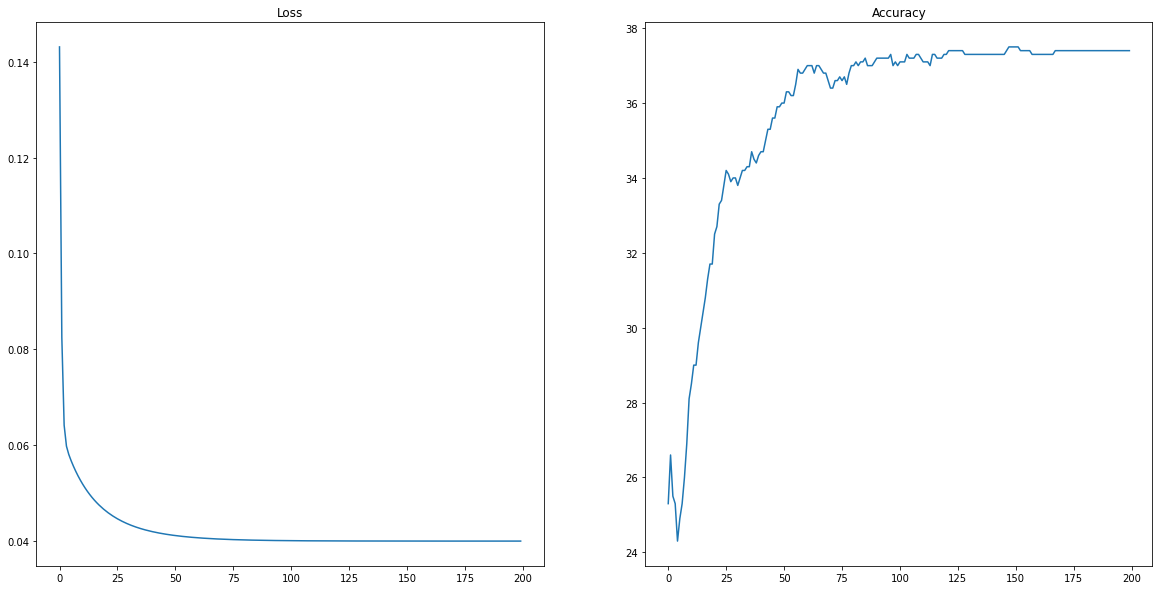

In [94]:
_, axes = plt.subplots(1, 2, figsize=(20, 10))
sns.lineplot(x=view.keys(), y=view.values(), ax=axes[0]).set(title="Loss")
sns.lineplot(x=test.accuracies.keys(), y=test.accuracies.values(), ax=axes[1]).set(title="Accuracy")
plt.show()